In [ ]:
import os
import glob
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from datetime import datetime
import matplotlib.pyplot as plt

In [51]:
ROOT_DIR = "./cifar-10-batches-py"
train_batches_pkl = sorted(glob.glob(ROOT_DIR + "/data_batch_*"))
train_batches_pkl

['./cifar-10-batches-py/data_batch_1',
 './cifar-10-batches-py/data_batch_2',
 './cifar-10-batches-py/data_batch_3',
 './cifar-10-batches-py/data_batch_4',
 './cifar-10-batches-py/data_batch_5']

In [52]:
test_batch_pkl = os.path.join(ROOT_DIR, "test_batch")
test_batch_pkl

'./cifar-10-batches-py/test_batch'

In [53]:
meta_data_pkl = os.path.join(ROOT_DIR, "batches.meta")
meta_data_pkl

'./cifar-10-batches-py/batches.meta'

In [54]:
train_batches = []
for batch in train_batches_pkl:
    with open(batch, "rb") as f:
        train_batches.append(pickle.load(f, encoding="latin1"))

In [55]:
with open(test_batch_pkl, "rb") as f:
    test_batch = pickle.load(f, encoding="latin1")

In [56]:
with open(meta_data_pkl, "rb") as f:
    meta_data = pickle.load(f, encoding="latin1")

meta_data

{'num_cases_per_batch': 10000,
 'label_names': ['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'],
 'num_vis': 3072}

In [57]:
train_images = []
train_labels = []
for batch in train_batches:
    data = batch["data"]
    train_labels.append(batch["labels"])
    arr_splits = list(map(lambda x: np.array_split(x, 3), data))
    reshaped_pixels = list(map(lambda x: [each_split.reshape((32, 32)) for each_split in x], arr_splits))
    stacked_3d_images = np.array(list(map(lambda x: np.stack(x).transpose(1, 2, 0), reshaped_pixels)))
    train_images.append(stacked_3d_images)

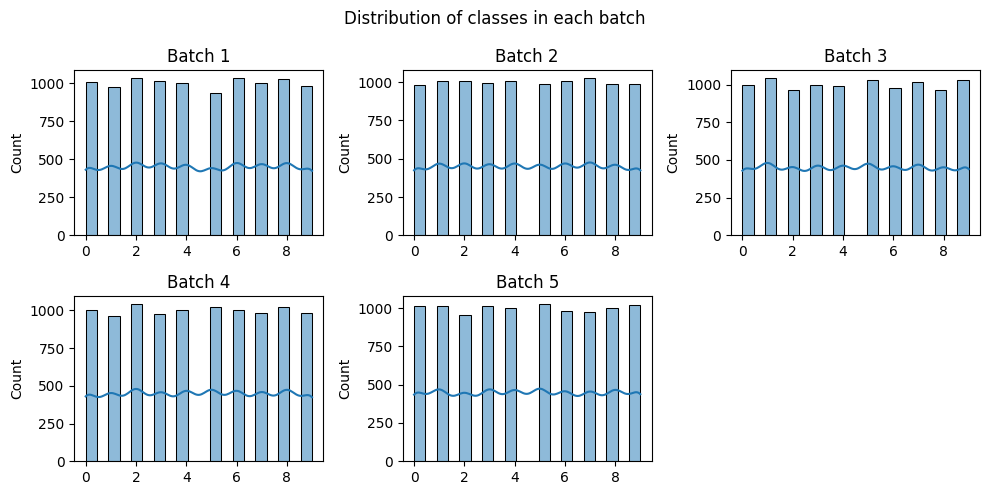

In [58]:
plt.figure(figsize=(10, 5))
for i, batch in enumerate(train_labels, 1):
    plt.subplot(2, 3, i)
    sns.histplot(batch, kde=True)
    plt.title(f"Batch {i}")

plt.suptitle("Distribution of classes in each batch")
plt.tight_layout()

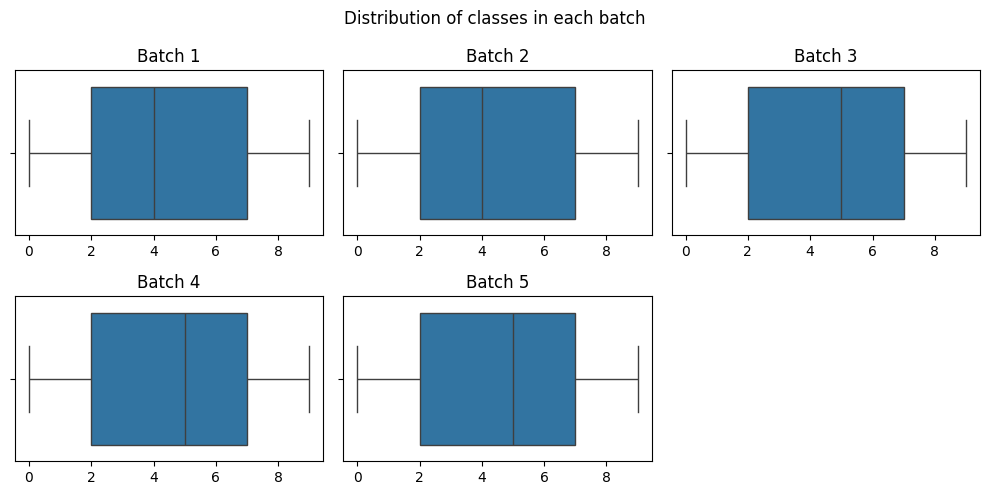

In [59]:
plt.figure(figsize=(10, 5))
for i, batch in enumerate(train_labels, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(batch, orient="h")
    plt.title(f"Batch {i}")

plt.suptitle("Distribution of classes in each batch")
plt.tight_layout()

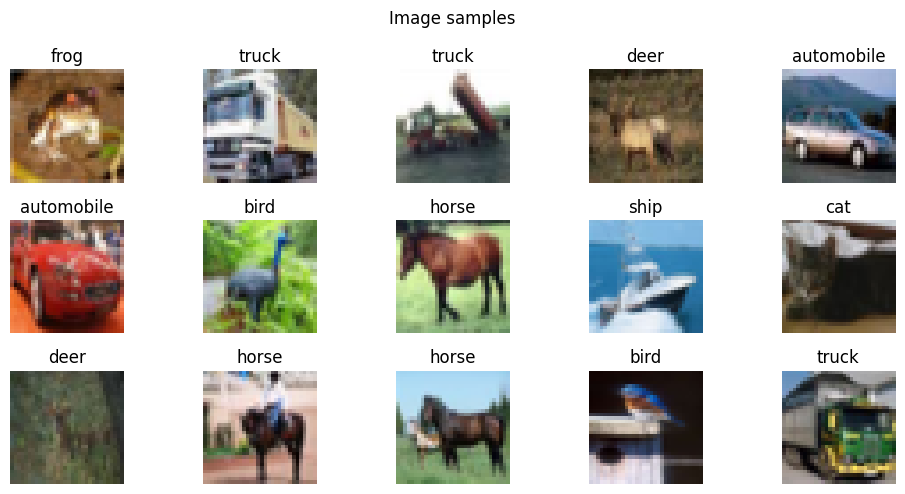

In [60]:
fig = plt.figure(figsize=(10, 5))
for i, (image, label) in enumerate(zip(train_images[0][:15], train_labels[0][:15]), 1):
    plt.subplot(3, 5, i)
    plt.imshow(image)
    plt.axis("off")
    plt.title(meta_data["label_names"][label])

plt.suptitle("Image samples")
plt.tight_layout()

In [61]:
train_labels_cat = tf.keras.utils.to_categorical(train_labels)
train_labels_cat.shape

(5, 10000, 10)

Merging the batches into a single batch!

In [62]:
X = np.concatenate(train_images)
print(f"X: {X.shape}")
y = np.concatenate(train_labels_cat)
print(f"y: {y.shape}")

X: (50000, 32, 32, 3)
y: (50000, 10)


## Model 1

In [63]:
ROOT_LOG_DIR = "logs"

def get_log_dir(subdir=None):
    run_id = datetime.now().strftime("%d_%m_%Y_%H_%M_%S")
    if subdir is None:
        return os.path.join(ROOT_LOG_DIR, run_id)
    return os.path.join(ROOT_LOG_DIR, subdir, run_id)

In [64]:
model1 = tf.keras.Sequential([
    tf.keras.Input((32, 32, 3)),
    tf.keras.layers.Conv2D(12, kernel_size=(3, 3), activation="relu"),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
    tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
    # Linear layers
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    # Softmax output
    tf.keras.layers.Dense(10, activation="softmax"),
])

In [65]:
checkpoint_path = "checkpoints/model1/cp.ckpt"

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                       monitor="val_loss", save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5),
    tf.keras.callbacks.TensorBoard(log_dir=get_log_dir("model1"))
]

In [66]:
model1.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-4), 
               loss="categorical_crossentropy", metrics=["accuracy"])

In [67]:
history1 = model1.fit(X, y, batch_size=128, 
                      epochs=20, validation_split=0.2, 
                      callbacks=callbacks)

Epoch 1/20
313/313 [==============================] - 86s 274ms/step - loss: 2.3415 - accuracy: 0.3924 - val_loss: 1.4132 - val_accuracy: 0.5057
Epoch 2/20
313/313 [==============================] - 80s 254ms/step - loss: 1.1851 - accuracy: 0.5870 - val_loss: 1.2519 - val_accuracy: 0.5668
Epoch 3/20
313/313 [==============================] - 79s 253ms/step - loss: 0.9151 - accuracy: 0.6888 - val_loss: 1.2387 - val_accuracy: 0.5861
Epoch 4/20
313/313 [==============================] - 81s 259ms/step - loss: 0.6803 - accuracy: 0.7761 - val_loss: 1.2550 - val_accuracy: 0.5948
Epoch 5/20
313/313 [==============================] - 80s 256ms/step - loss: 0.4820 - accuracy: 0.8458 - val_loss: 1.3520 - val_accuracy: 0.5930
Epoch 6/20
313/313 [==============================] - 80s 255ms/step - loss: 0.3228 - accuracy: 0.9016 - val_loss: 1.3646 - val_accuracy: 0.6006
Epoch 7/20
313/313 [==============================] - 80s 256ms/step - loss: 0.2039 - accuracy: 0.9456 - val_loss: 1.5134 - val_ac

In [68]:
model1.load_weights(checkpoint_path)

<Axes: >

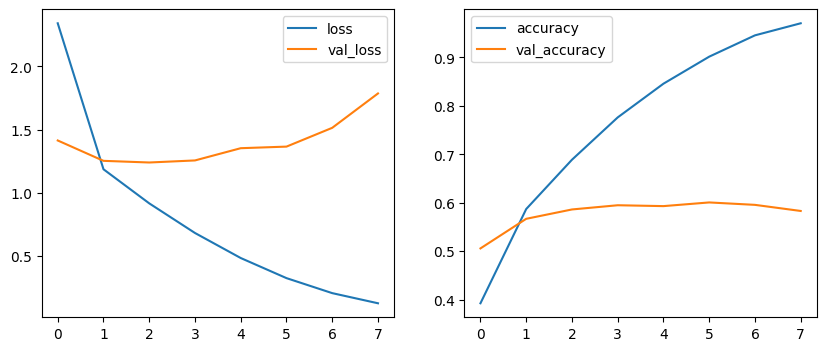

In [ ]:
history1_df = pd.DataFrame(history1.history)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

history1_df[['loss', 'val_loss']].plot(ax=axes[0])
history1_df[['accuracy', 'val_accuracy']].plot(ax=axes[1])
plt.title("Model 1 training curves")

Overfitting by a lot

## Model 2

In [70]:
from tensorflow.keras.applications.resnet50 import ResNet50


keras.backend.clear_session()
model2 = tf.keras.Sequential([
    ResNet50(include_top=False, input_shape=(32, 32, 3), classes=10, classifier_activation="softmax", pooling="avg"),
    tf.keras.layers.Dense(10, activation="softmax"),
])

In [71]:
checkpoint_path = "checkpoints/model2/cp.ckpt"

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                       monitor="val_loss", save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5),
    tf.keras.callbacks.TensorBoard(log_dir=get_log_dir("model2"))
]

In [72]:
model2.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-4), 
               loss="categorical_crossentropy", metrics=["accuracy"])

In [73]:
history2 = model2.fit(X, y, batch_size=128, 
                      epochs=20, validation_split=0.2, 
                      callbacks=callbacks)

Epoch 1/20
313/313 [==============================] - 364s 1s/step - loss: 1.4971 - accuracy: 0.5209 - val_loss: 0.9655 - val_accuracy: 0.6747
Epoch 2/20
313/313 [==============================] - 356s 1s/step - loss: 0.6899 - accuracy: 0.7664 - val_loss: 0.8607 - val_accuracy: 0.7112
Epoch 3/20
313/313 [==============================] - 357s 1s/step - loss: 0.3749 - accuracy: 0.8749 - val_loss: 0.8208 - val_accuracy: 0.7378
Epoch 4/20
313/313 [==============================] - 363s 1s/step - loss: 0.2070 - accuracy: 0.9334 - val_loss: 0.8556 - val_accuracy: 0.7462
Epoch 5/20
313/313 [==============================] - 360s 1s/step - loss: 0.1376 - accuracy: 0.9567 - val_loss: 0.9221 - val_accuracy: 0.7475
Epoch 6/20
313/313 [==============================] - 366s 1s/step - loss: 0.0992 - accuracy: 0.9689 - val_loss: 0.9725 - val_accuracy: 0.7522
Epoch 7/20
313/313 [==============================] - 353s 1s/step - loss: 0.0915 - accuracy: 0.9711 - val_loss: 0.9963 - val_accuracy: 0.7497

In [74]:
model2.load_weights(checkpoint_path)

<Axes: >

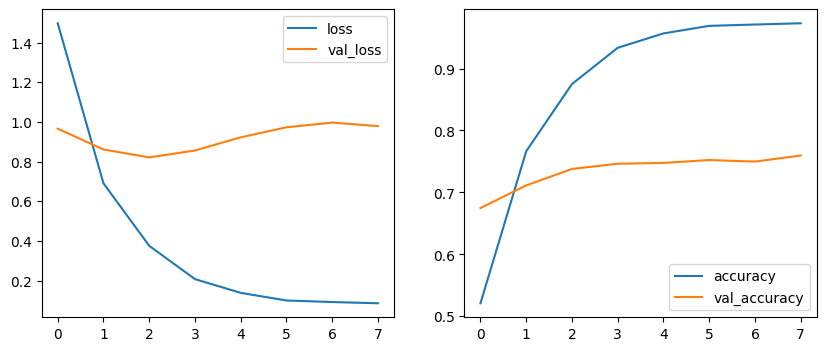

In [75]:
history2_df = pd.DataFrame(history2.history)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

history2_df[['loss', 'val_loss']].plot(ax=axes[0])
history2_df[['accuracy', 'val_accuracy']].plot(ax=axes[1])
plt.title("Model 2 training curves")

## Model 3

In [76]:
keras.backend.clear_session()

class ConvBlock(tf.keras.layers.Layer):
    def __init__(self, out_channels, kernel_size=(3, 3), **kwargs):
        super(ConvBlock, self).__init__(**kwargs)
        self.hidden = [
            tf.keras.layers.Conv2D(out_channels, kernel_size=kernel_size),
            tf.keras.layers.ELU(),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(out_channels, kernel_size=kernel_size),
            tf.keras.layers.ELU(),
            tf.keras.layers.BatchNormalization(),
        ]
    
    def call(self, inputs):
        for layer in self.hidden:
            inputs = layer(inputs)

        return inputs


model3 = tf.keras.Sequential([
    tf.keras.Input((32, 32, 3)),

    # Conv set 1
    ConvBlock(32),
    tf.keras.layers.Dropout(0.3),
    ConvBlock(64),
    tf.keras.layers.Dropout(0.4),
    ConvBlock(128),
    tf.keras.layers.Dropout(0.5),

    # Linear layers
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    # Softmax output
    tf.keras.layers.Dense(10, activation="softmax"),
])

In [77]:
checkpoint_path = "checkpoints/model3/cp.ckpt"

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                       monitor="val_loss", save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5),
    tf.keras.callbacks.TensorBoard(log_dir=get_log_dir("model3"))
]

In [78]:
model3.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-4), 
               loss="categorical_crossentropy", metrics=["accuracy"])

In [79]:
history3 = model3.fit(X, y, batch_size=128, 
                      epochs=20, validation_split=0.2, 
                      callbacks=callbacks)

Epoch 1/20
313/313 [==============================] - 274s 874ms/step - loss: 1.8876 - accuracy: 0.3363 - val_loss: 1.5411 - val_accuracy: 0.4453
Epoch 2/20
313/313 [==============================] - 274s 874ms/step - loss: 1.5077 - accuracy: 0.4575 - val_loss: 1.3844 - val_accuracy: 0.5108
Epoch 3/20
313/313 [==============================] - 282s 901ms/step - loss: 1.3537 - accuracy: 0.5187 - val_loss: 1.2496 - val_accuracy: 0.5622
Epoch 4/20
313/313 [==============================] - 254s 811ms/step - loss: 1.2385 - accuracy: 0.5593 - val_loss: 1.2110 - val_accuracy: 0.5778
Epoch 5/20
313/313 [==============================] - 246s 786ms/step - loss: 1.1497 - accuracy: 0.5938 - val_loss: 1.1344 - val_accuracy: 0.6018
Epoch 6/20
313/313 [==============================] - 239s 762ms/step - loss: 1.0675 - accuracy: 0.6191 - val_loss: 1.0913 - val_accuracy: 0.6250
Epoch 7/20
313/313 [==============================] - 251s 801ms/step - loss: 0.9895 - accuracy: 0.6494 - val_loss: 1.0181 -

In [80]:
model3.load_weights(checkpoint_path)

<Axes: >

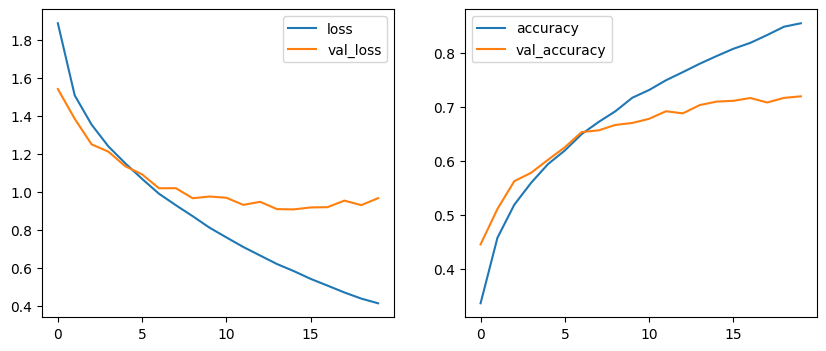

In [81]:
history3_df = pd.DataFrame(history3.history)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

history3_df[['loss', 'val_loss']].plot(ax=axes[0])
history3_df[['accuracy', 'val_accuracy']].plot(ax=axes[1])
plt.title("Model 3 training curves")

## Model 4

In [95]:
keras.backend.clear_session()

class ConvBlock(tf.keras.layers.Layer):
    def __init__(self, out_channels, kernel_size=(3, 3), **kwargs):
        super(ConvBlock, self).__init__(**kwargs)
        self.hidden = [
            tf.keras.layers.Conv2D(out_channels, kernel_size=kernel_size),
            tf.keras.layers.ReLU(),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(out_channels, kernel_size=kernel_size),
            tf.keras.layers.ReLU(),
            tf.keras.layers.BatchNormalization(),
        ]
    
    def call(self, inputs):
        for layer in self.hidden:
            inputs = layer(inputs)

        return inputs


model4 = tf.keras.Sequential([
    tf.keras.Input((32, 32, 3)),

    # Conv set 1
    ConvBlock(32),
    tf.keras.layers.Dropout(0.3),
    ConvBlock(64),
    tf.keras.layers.Dropout(0.4),
    ConvBlock(128),
    tf.keras.layers.Dropout(0.5),

    # Linear layers
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    # Softmax output
    tf.keras.layers.Dense(10, activation="softmax"),
])

In [96]:
checkpoint_path = "checkpoints/model4/cp.ckpt"

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                       monitor="val_loss", save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5),
    tf.keras.callbacks.TensorBoard(log_dir=get_log_dir("model4"))
]

In [97]:
model4.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-4), 
               loss="categorical_crossentropy", metrics=["accuracy"])

In [101]:
history4 = model4.fit(X, y, batch_size=128, 
                      epochs=20, validation_split=0.2, 
                      callbacks=callbacks)

Epoch 1/20
313/313 [==============================] - 255s 808ms/step - loss: 1.7936 - accuracy: 0.3487 - val_loss: 1.6246 - val_accuracy: 0.4214
Epoch 2/20
313/313 [==============================] - 267s 852ms/step - loss: 1.5001 - accuracy: 0.4600 - val_loss: 1.4138 - val_accuracy: 0.5068
Epoch 3/20
313/313 [==============================] - 260s 830ms/step - loss: 1.3570 - accuracy: 0.5124 - val_loss: 1.2922 - val_accuracy: 0.5466
Epoch 4/20
313/313 [==============================] - 249s 794ms/step - loss: 1.2486 - accuracy: 0.5556 - val_loss: 1.2642 - val_accuracy: 0.5598
Epoch 5/20
313/313 [==============================] - 252s 805ms/step - loss: 1.1539 - accuracy: 0.5882 - val_loss: 1.1688 - val_accuracy: 0.5954
Epoch 6/20
313/313 [==============================] - 241s 771ms/step - loss: 1.0662 - accuracy: 0.6180 - val_loss: 1.1408 - val_accuracy: 0.6099
Epoch 7/20
313/313 [==============================] - 249s 796ms/step - loss: 0.9829 - accuracy: 0.6491 - val_loss: 1.0544 -

In [102]:
model4.load_weights(checkpoint_path)

<Axes: >

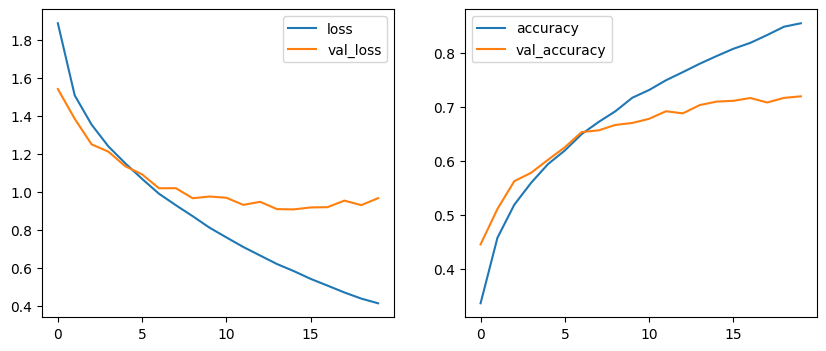

In [103]:
history4_df = pd.DataFrame(history4.history)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

history4_df[['loss', 'val_loss']].plot(ax=axes[0])
history4_df[['accuracy', 'val_accuracy']].plot(ax=axes[1])
plt.title("Model 4 training curves")

### Testing

In [ ]:
test_data = test_batch["data"]
test_labels = batch["labels"]
arr_splits = list(map(lambda x: np.array_split(x, 3), test_data))
reshaped_pixels = list(map(lambda x: [each_split.reshape((32, 32)) for each_split in x], arr_splits))
test_images = np.array(list(map(lambda x: np.stack(x).transpose(1, 2, 0), reshaped_pixels)))

test_labels_cat = tf.keras.utils.to_categorical(test_labels)

model4.evaluate(test_images, test_labels_cat)

In [ ]:
%tensorboard